In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils
import magic


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [12]:
# aesthetics
# cmap_timepoint = {v:sns.light_palette((210, 90, 60), input="husl")[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [34]:
if True:
    # do the human ones
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'

    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = utils.load_adata(os.path.join(pdfp, fname))
    
    if True : # not encoded yet
        hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
if True:
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'
    
    %memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))
    
if False:
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'

    %memit wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))
    %memit mutt = utils.load_adata(os.path.join(pdfp, 'mouse_sca1_imputed.h5ad'))
    
    

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


loaded @200807.13:51:23
took 9.83-s to load data
peak memory: 20630.88 MiB, increment: 10177.49 MiB
loaded @200807.13:51:39
took 15.51-s to load data
peak memory: 31192.31 MiB, increment: 10561.43 MiB


# Human

In [54]:


order_human=[
    'Granule cell',
    'GABAergic interneuron 1',
    'GABAergic interneuron 2',
    'Astrocyte',
    'Bergmann glia',
    'Oligodendrocyte progenitor cell',
    'Oligodendrocyte',
    'Microglia',
    'Pericyte',
]

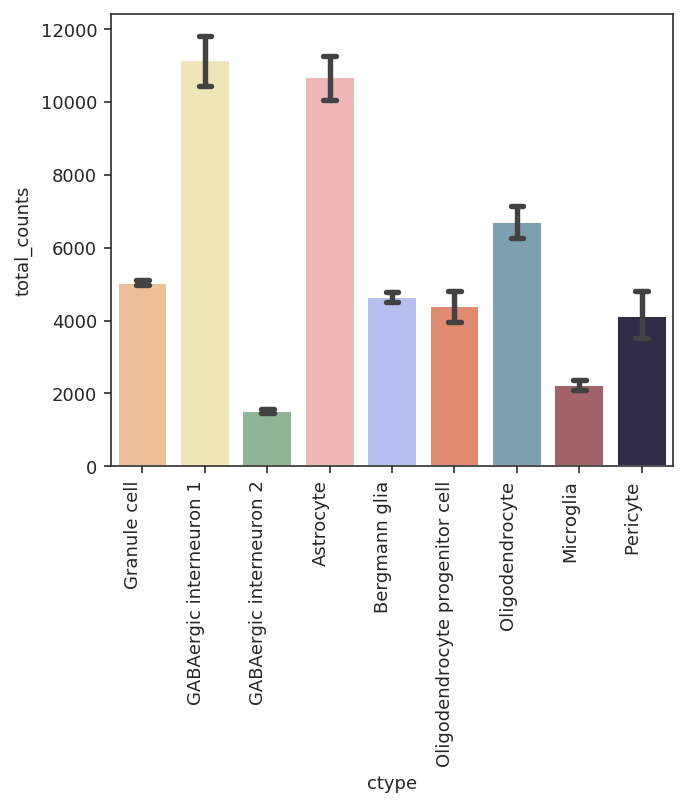

In [55]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

sns.barplot(x='ctype', 
               y='total_counts', 
               data=hdata.obs, 
               dodge=False, 
               ax=ax, 
               hue='ctype', 
               palette=cmap_ctype,
               capsize=.2,
               order=order_human)

# ax.set_ylim([0, 50000])
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

fig.savefig(os.path.join(pfp, 'umi_count_hum_by_ctype.pdf'))

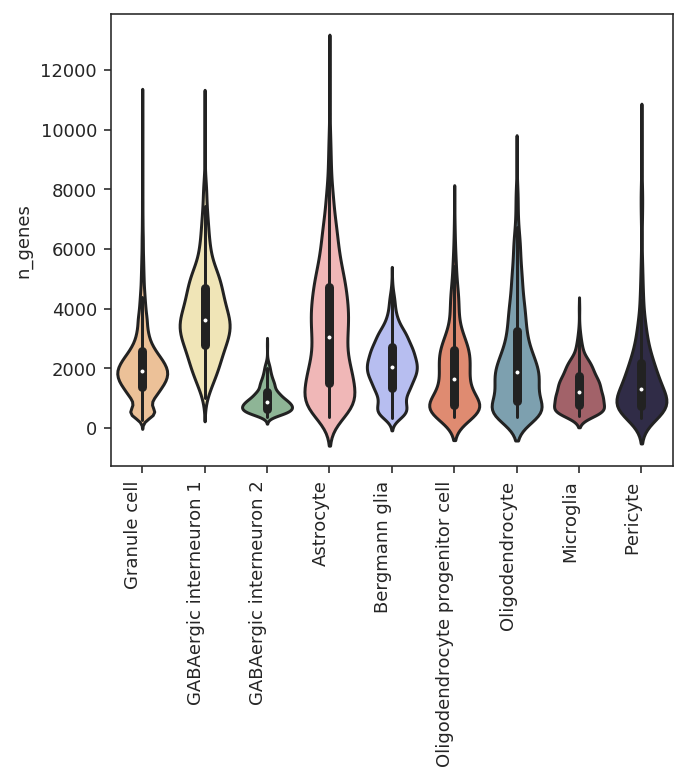

In [62]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.violinplot(x='ctype', y='n_genes', data=hdata.obs, dodge=False, ax=ax, hue='ctype', palette=cmap_ctype,
              order=order_human)
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_xlabel('')
fig.savefig(os.path.join(pfp, 'n_genes_human_by_ctype.pdf'))

In [58]:
hdata.obs['n_genes_post-MAGIC'] = (hdata.layers['imputed_bbknn']>0).sum(axis=1)

[Text(0, 0, 'Granule cell'),
 Text(0, 0, 'Bergmann glia'),
 Text(0, 0, 'Oligodendrocyte'),
 Text(0, 0, 'Astrocyte'),
 Text(0, 0, 'GABAergic interneuron 1'),
 Text(0, 0, 'GABAergic interneuron 2'),
 Text(0, 0, 'Oligodendrocyte progenitor cell'),
 Text(0, 0, 'Pericyte'),
 Text(0, 0, 'Microglia')]

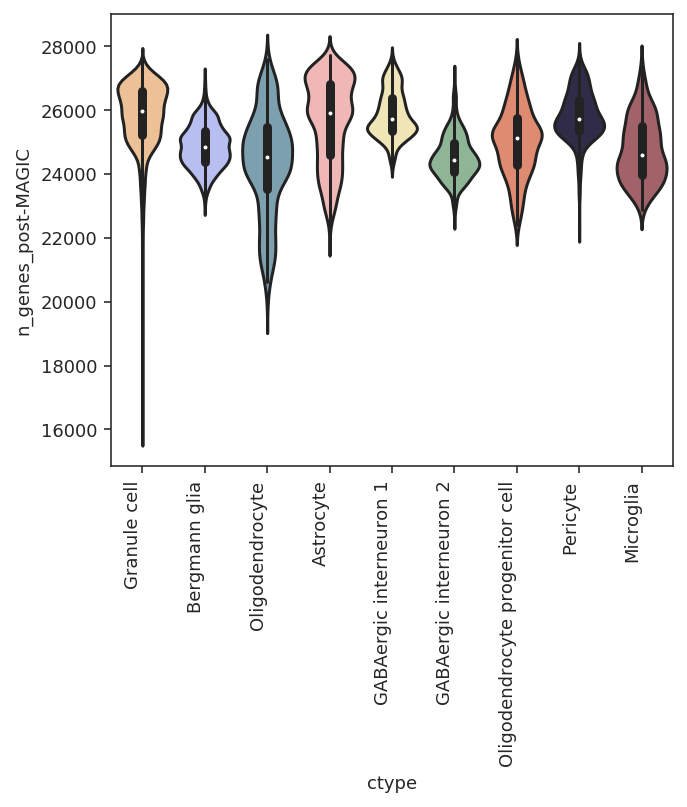

In [59]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.violinplot(x='ctype', y='n_genes_post-MAGIC', data=hdata.obs, dodge=False, ax=ax, hue='ctype', palette=cmap_ctype)
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_xlabel('')

In [68]:
hdata.obs.groupby('ctype').median()['n_genes']

ctype
Granule cell                       1922.0
Bergmann glia                      2049.0
Oligodendrocyte                    1878.5
Astrocyte                          3032.0
GABAergic interneuron 1            3619.0
GABAergic interneuron 2             853.0
Oligodendrocyte progenitor cell    1642.0
Pericyte                           1312.0
Microglia                          1200.0
Name: n_genes, dtype: float64

In [70]:
hdata.obs.groupby('ctype').mean()['total_counts']

ctype
Granule cell                        5039.845703
Bergmann glia                       4645.982910
Oligodendrocyte                     6710.738281
Astrocyte                          10688.262695
GABAergic interneuron 1            11158.166016
GABAergic interneuron 2             1514.586426
Oligodendrocyte progenitor cell     4393.222168
Pericyte                            4130.308594
Microglia                           2243.330322
Name: total_counts, dtype: float32

In [72]:
np.mean([6,4,4])

4.666666666666667

# Mouse

In [52]:
order_mouse=[
    'Granule cell',
    'Unipolar brush cell',
    'Purkinje cell',
    'GABAergic interneuron 1',
    'GABAergic interneuron 2',
    'GABAergic interneuron 3',
    'Astrocyte',
    'Bergmann glia',
    'Oligodendrocyte progenitor cell',
    'Oligodendrocyte',
    'Microglia',
    'Pericyte',
    'Endothelial cell',
]

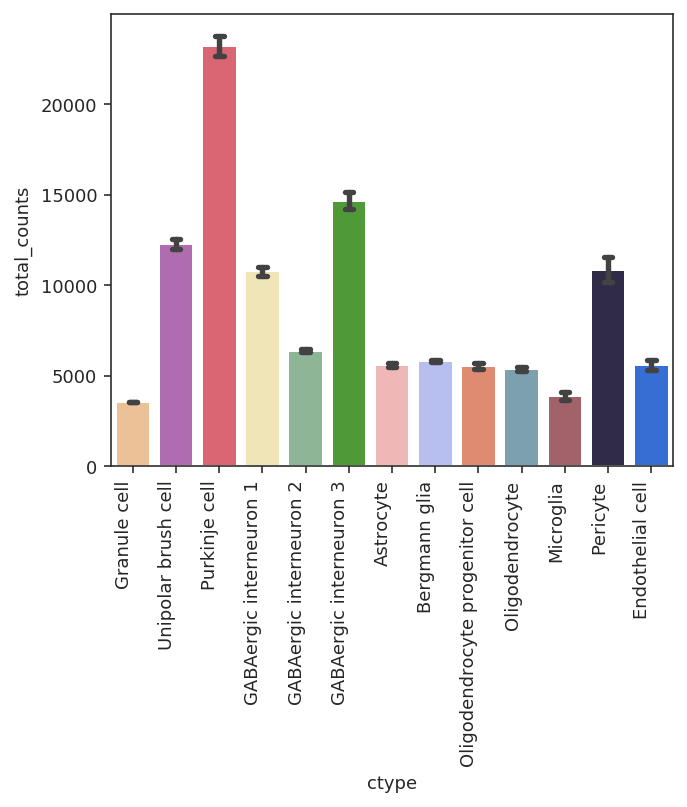

In [53]:
# dev
fig, ax = plt.subplots(1,1, figsize=(5,4))
# sns.stripplot(x='ctype', 
#                y='total_counts', 
#                data=adata.obs, 
#                dodge=False, 
#                ax=ax, 
#                hue='ctype', 
#                palette=cmap_ctype,
#                rasterized=True,
#                s=0.5,
#                alpha=0.2)
# #                linewidth=0)

sns.barplot(x='ctype', 
               y='total_counts', 
               data=adata.obs, 
               dodge=False, 
               ax=ax, 
               hue='ctype', 
               palette=cmap_ctype,
               capsize=.2,
               order=order_mouse)

# ax.set_ylim([0, 50000])
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

fig.savefig(os.path.join(pfp, 'umi_count_mouse_by_ctype.pdf'))



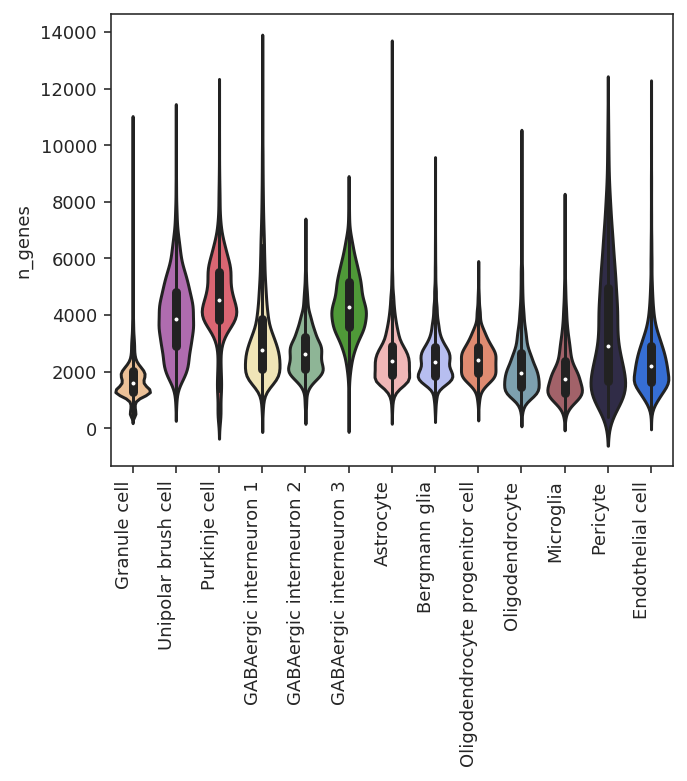

In [63]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.violinplot(x='ctype', y='n_genes', data=adata.obs, dodge=False, ax=ax, hue='ctype', palette=cmap_ctype,
              order=order_mouse)
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_xlabel('')
fig.savefig(os.path.join(pfp, 'n_genes_mouse_by_ctype.pdf'))

In [67]:
adata.obs.groupby('ctype').mean()['total_counts']

ctype
Astrocyte                           5578.126953
Bergmann glia                       5803.935547
Endothelial cell                    5582.273926
GABAergic interneuron 1            10762.512695
GABAergic interneuron 2             6390.188965
GABAergic interneuron 3            14661.022461
Granule cell                        3533.712158
Microglia                           3886.952393
Oligodendrocyte                     5384.851562
Oligodendrocyte progenitor cell     5552.721191
Pericyte                           10859.645508
Purkinje cell                      23204.093750
Unipolar brush cell                12282.712891
Name: total_counts, dtype: float32